[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)][collabURL]

# Module 0 - Homework 1 - Twitter Sentiment Analysis

**Author** : Victor Calderon


## Problem Statement

Airline industry had a very hard time post-covid to sustain their business
due to a long hault. It is very important for them to make sure they exceed
customer expectations. The best way to evaluate performance is customer
feedback. You are given a dataset of *airline tweets* from real customers.

A sentiment analysis job about the problems of each major U.S. airline.
Twitter data was scraped from *February of 2015* and contributors
were asked to first classify *positive*, *negative*, and *neutral* tweents,
followed by categorizing *negative reasons* (e.g. "late flight", or
"rude service").

You will use the text column and sentiment column to create a classification
model that classifies a given tween into one of the 3 classes:

- Positive
- Negative
- Neutral

Source: [Notebook][HomeworkNotebookURL]

## Understanding the dataset

Dataset contains many columns, out of which below are most important ones:

1. `airline_sentiment` : Defines the sentiment of the tweet
2. `negative_reason` : Reason for the negative feedback (if negative).
3. `Text` : Tweet text content
4. `tweet_location` : Location, from which the tweet was posted.

## Steps to perform

1. Load dataset: [link][datasetURL]
2. Clean, preprocess data and EDA.
3. Vectorise columns that contain text.
4. Run classification model to classify - *positive*, *negative*, or *neutral*.
5. Evaluate model.

<!-- Links -->

[jupyterNotebook]: https://github.com/hamzafarooq/maven-mlsystem-design-cohort-1/blob/main/Module-0/airline_tweet_sentiment.ipynb

[datasetURL]: https://www.kaggle.com/datasets/crowdflower/twitter-airline-sentiment

[spacyURL]: https://spacy.io/

[kaggleURL]: https://www.kaggle.com/

[nltkURL]: https://www.nltk.org/

[collabURL]: https://colab.research.google.com/github/vcalderon2009/ML-System-Design-Course/blob/main/modules/Module_0/Homework/01-Victor-Calderon-Module-0-Homework-1-Twitter-Sentiment-Analysis.ipynb

[HomeworkNotebookURL]: https://github.com/hamzafarooq/maven-mlsystem-design-cohort-1/blob/main/Module-0/airline_tweet_sentiment.ipynb

---

## 0.1 Loading modules

In [1]:
# Installing 'contextualSpellCheck'
!pip install -q contextualSpellCheck

In [2]:
# Installing Kaggle, if necessary
!pip install -q kaggle

In [3]:
# Installing spacy
!pip install -q spacy

In [4]:
# Installing NLTK
!pip install -q nltk

In [5]:
!pip install -q -r https://raw.githubusercontent.com/vcalderon2009/ML-System-Design-Course/feature/module-0-intro-to-nlp/requirements.txt

In [6]:
# Downloading the English language
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 196.2 kB/s eta 0:00:00m eta 0:00:010:00:02
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [7]:
from pathlib import Path
import shutil
import os
import tempfile
import logging
from zipfile import ZipFile
from typing import Optional
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing as skp
from nltk.tokenize import TweetTokenizer
import nltk
import string
import re
import spacy
import contextualSpellCheck
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, f1_score, auc, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn import svm
from sklearn.naive_bayes import MultinomialNB

plt.style.use("seaborn")

logger = logging.getLogger(__name__)
logging.basicConfig(level=logging.INFO)

/var/folders/lm/rc_j1sgx687267y6tjc4l5600000gn/T/ipykernel_31808/180191467.py:25: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


## 0.2 Defining utility functions

Before we begin, we'll need to define some utility functions in order to
not clutter the notebook.

In [8]:
def create_temp_directory():
    """
    Function to create a temporary directory.
    
    Returns
    ---------
    temp_dir : pathlib.Path
        Path to the temporary directory
    """
    # Defining a temporary directory
    temp_dir = tempfile.mkdtemp()
    Path(temp_dir).mkdir(exist_ok=True, parents=True)
    
    return Path(temp_dir).resolve()

In [9]:
def run_system_command(cmd: str):
    """
    Function to run a system command
    """
    os.system(cmd)

In [10]:
def get_kaggle_credentials():
    """
    Function to get the API credentials for interacting with Kaggle.
    """
    # Determining which type of setting to use
    try:
        from google.colab import drive

        COLAB_WORKSPACE = True
    except:
        COLAB_WORKSPACE = False
    #
    if COLAB_WORKSPACE:
        # Asking the user to upload the `kaggle.json` credentials file
        from google.colab import files
        files.upload()

        # Creating directory to place the credentials
        kaggle_output_directory = Path("~").resolve()
        kaggle_output_directory.mkdir(exist_ok=True, parents=True)

        # Specifying the variable in the system
        os.environ["KAGGLE_CONFIG_DIR"] = str(kaggle_output_directory)

        # Copying credentials to kaggle directory
        kaggle_creds_output_filepath = kaggle_output_directory.joinpath(
            "kaggle.json"
        )
        shutil.copy("./kaggle.json", kaggle_creds_output_filepath)

        # Changing the permissions of the file
        kaggle_creds_output_filepath.chmod(600)


In [11]:
def get_kaggle_dataset_and_load(
    username: str,
    dataset_name: str,
    extension: Optional[str] = "csv",
    delete_file: Optional[bool] = False,
) -> pd.DataFrame:
    """
    Function to download a dataset from Kaggle.

    Parameters
    -----------
    username : str
        Username that owns the dataset.

    dataset_name : str
        Name of the dataset.

    extension : str, optional
        File extension of the uncompressed dataset.

    delete_file : bool, optional
        If ``True``, the uncompressed file will be deleted.
        This variable is set to ``False`` by default.

    Returns
    ----------
    dataset_df : pandas.DataFrame
        Dataset from Kaggle
    """
    # Creating temporary directory
    temp_dir = create_temp_directory()
    # Downloading the specified dataset
    cmd = f"kaggle datasets download {username}/{dataset_name}"
    logging.info(cmd)
    run_system_command(cmd=cmd)
    # Find the `.zip` file, move it to the temporary directory and unzip it
    dataset_zip_filepath = list(Path(".").resolve().glob("*.zip"))[0]
    # Decompressing file
    with ZipFile(str(dataset_zip_filepath), "r") as zfile:
        zfile.extractall(path=temp_dir)

    # Figuring out the path to the uncompressed file
    dataset_filepath = list(temp_dir.rglob(f"*.{extension}"))[0]
    logger.info(f"Uncompressed dataset: `{dataset_filepath}` downloaded!")

    # Reading in data
    read_func = {
        ".csv": pd.read_csv,
        ".parquet": pd.read_parquet,
        ".json": pd.read_json,
    }

    file_extension = dataset_filepath.suffix

    dataset_df = read_func[file_extension](dataset_filepath)

    # Deleting dataset
    logger.info(f"dataset_zip_filepath: {dataset_zip_filepath}")
    dataset_zip_filepath.unlink()

    if delete_file:
        dataset_filepath.unlink()

    return dataset_df


---

## 1. Downloading and loading the Kaggle dataset

The first step is to download the Kaggle dataset. In order to do this, we will have to use the
Kaggle API keys / credentials to download the Kaggle dataset directly.

In [12]:
# Getting Kaggle Credentials
get_kaggle_credentials()

In [13]:
# Defining the username and name of the dataset
KAGGLE_DATASET_USERNAME = "crowdflower"
KAGGLE_DATASET_NAME = "twitter-airline-sentiment"

dataset_df = get_kaggle_dataset_and_load(
    username=KAGGLE_DATASET_USERNAME,
    dataset_name=KAGGLE_DATASET_NAME,
)


INFO:root:kaggle datasets download crowdflower/twitter-airline-sentiment


100%|██████████| 2.55M/2.55M [00:00<00:00, 4.56MB/s]
INFO:__main__:Uncompressed dataset: `/private/var/folders/lm/rc_j1sgx687267y6tjc4l5600000gn/T/tmp3y8gya5e/Tweets.csv` downloaded!


INFO:__main__:dataset_zip_filepath: /Users/vfcalderon/Documents/Repositories/Courses/ML-System-Design-Course/modules/Module_0/Homework/twitter-airline-sentiment.zip


In [14]:
dataset_df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


---

## 2. Clean, preprocess, and EDA

This section covers the steps for cleaning the data, run preprocessing tasks, as well as the EDA of the dataset.

### 2.1 Basic EDA

In this section, we'll cover the following EDA tasks:

- Shape of the dataset
- Null and duplicated values
- Distribution of the `airline_sentiment`.
- Check the confidence values (per type) for each type `airline_sentiment_confidence`.
- Look at what the *negative* reasons were for having a negative sentiment.

Extra:
- Look at whether or not some airlines have more positive or negative tweets, and possibly by time created.
- Number of tweets per season, per year, etc.
- Spikes over Time (after converting to UTC) time, i.e. where there any specific times, at which airlines
  failed their customers.

#### 2.1.1 - Shape and content of the dataset

In [15]:
logger.info("There are '{}' rows and '{}' columns in the dataset.".format(*dataset_df.shape))

INFO:__main__:There are '14640' rows and '15' columns in the dataset.


In terms of the data, we can see that the set of columns of the datasets is:

In [16]:
logger.info("Set of columns: \n\t{}".format('\n\t'.join(dataset_df.columns.tolist())))

INFO:__main__:Set of columns: 
	tweet_id
	airline_sentiment
	airline_sentiment_confidence
	negativereason
	negativereason_confidence
	airline
	airline_sentiment_gold
	name
	negativereason_gold
	retweet_count
	text
	tweet_coord
	tweet_created
	tweet_location
	user_timezone


#### 2.1.2 Null and duplicated values in the dataset

Another aspect that we can look at is the number of `Null` values for each column. This will indicate if the data is rather
sparse and could determine how the data is handled.

In [17]:
len(dataset_df)

14640

In [18]:
dataset_null_df = dataset_df.isnull().sum().to_frame().rename(columns={0:"Nulls"}).sort_values("Nulls")
dataset_null_df["Fraction_Nulls (%)"] = np.round(100*dataset_null_df["Nulls"] / len(dataset_df), 2)

dataset_null_df

,Nulls,Fraction_Nulls (%)
tweet_id,0,0.00
airline_sentiment,0,0.00
airline_sentiment_confidence,0,0.00
airline,0,0.00
name,0,0.00
retweet_count,0,0.00
text,0,0.00
tweet_created,0,0.00
negativereason_confidence,4118,28.13
tweet_location,4733,32.33


Let's look at the how many duplicated entries we have in the dataset:

In [19]:
logger.info(f"There is a total of '{dataset_df.duplicated().sum()}' duplicated entries in the dataset")

INFO:__main__:There is a total of '36' duplicated entries in the dataset


#### 2.1.3 Distribution of the airlines

Another aspect that we can look at is the distribution of tweets as function of airline:

<Axes: xlabel='airline'>

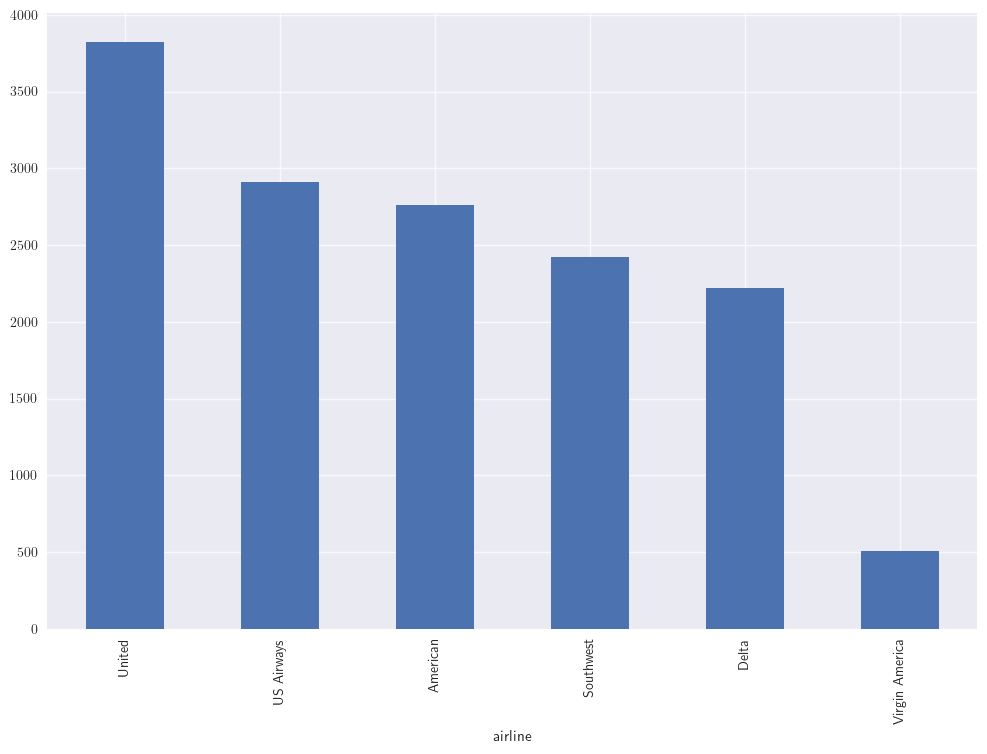

In [20]:
dataset_df["airline"].value_counts(dropna=True).plot(kind="bar", figsize=(12, 8))

We can go a step further and break it down per sentiment type for each airline:

<Axes: xlabel='airline'>

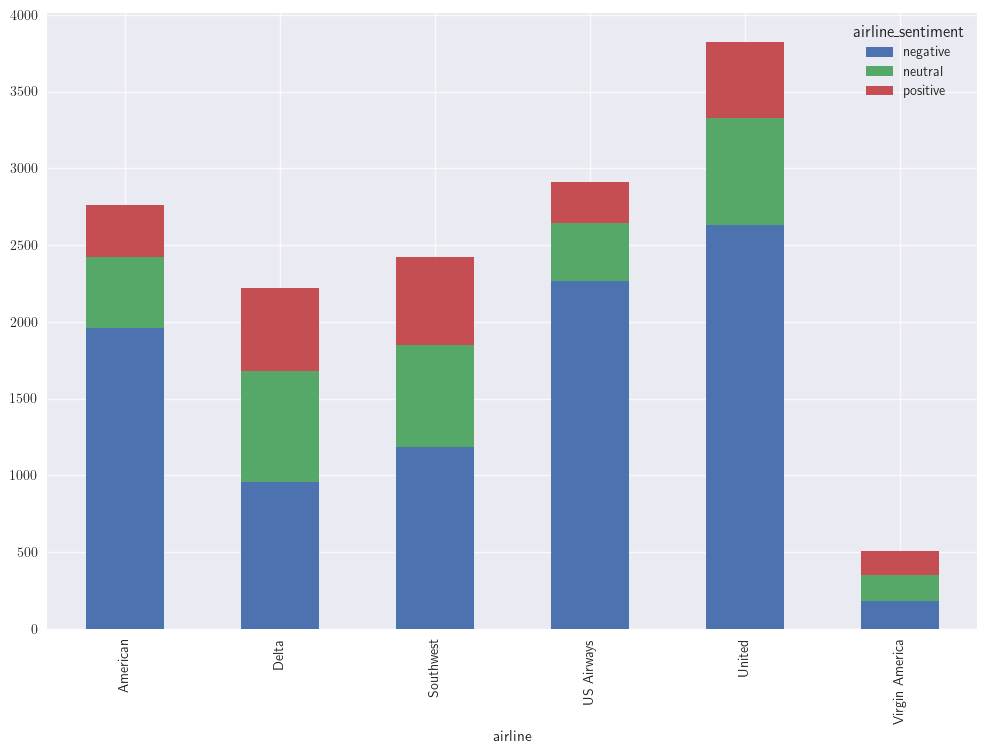

In [21]:
# Extracting the number of tweets per airline and categorizing them by their sentiment
dataset_df.groupby(by=["airline", "airline_sentiment"]).size().unstack().plot(kind="bar", stacked=True, figsize=(12, 8))

#### 2.1.4 Sentiment confidence as a function of sentiment

Similarly, we can take a look at the distribution of the sentiment of each tweet, and check for any imbalances in the dataset:

<Axes: xlabel='airline_sentiment_confidence', ylabel='Density'>

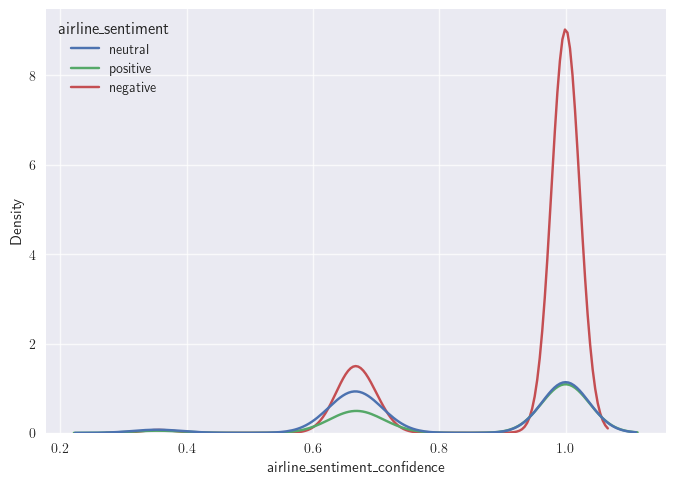

In [22]:
sns.kdeplot(data=dataset_df, x="airline_sentiment_confidence", hue="airline_sentiment")

The previous image shows the distribution of the `airline_sentiment` and it shows that there the confidence
values of the sentiment for each tweet is for the most part larger than `50%` for all types of sentiment.

#### 2.1.5 Reasons for why airlines got a bad review.

It is important to understand the reason behind any review. We can easily look at the `negativereason` column
and determine what the top reasons were for people to leave a bad review.

In [23]:
# Understanding the metrics for each tweet.
dataset_df["negativereason_confidence"].describe().to_frame()

,negativereason_confidence
count,10522.000000
mean,0.638298
std,0.330440
min,0.000000
25%,0.360600
50%,0.670600
75%,1.000000
max,1.000000


Let's also look at the fractions for each negative reason:

In [24]:
negative_reason_dataset = dataset_df["negativereason"].value_counts(dropna=True).to_frame()
negative_reason_dataset["Frac (%)"] = 100 * negative_reason_dataset / len(dataset_df)

negative_reason_dataset

,count,Frac (%)
negativereason,,
Customer Service Issue,2910,19.877049
Late Flight,1665,11.372951
Can't Tell,1190,8.128415
Cancelled Flight,847,5.785519
Lost Luggage,724,4.945355
Bad Flight,580,3.961749
Flight Booking Problems,529,3.613388
Flight Attendant Complaints,481,3.285519
longlines,178,1.215847


One takeaway from this result is that at least 1/3 of the negative reviews are due to:
- Customer Service Issue
- Late Flight

This is better shown in the following figure:

<Axes: xlabel='negativereason'>

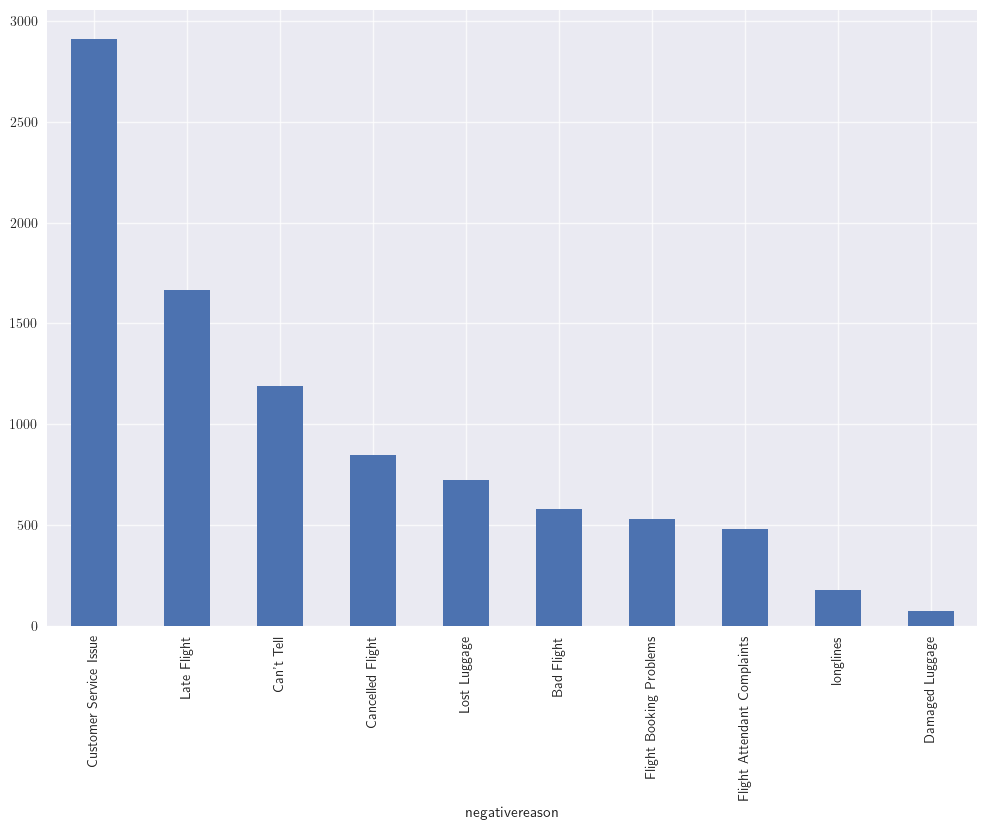

In [25]:
dataset_df["negativereason"].dropna().value_counts(dropna=False).plot(kind="bar", figsize=(12, 8))

The previous plot shows us that the top 4 reasons for someone to have left a negative review are:
- Customer Service Issue
- Late Flight
- Can't Tell
- Cancelled Flight

Similarly, one can look at this as a function of airline

In [26]:
# Distribution of 'negative reason' as function of airline
negative_reasons_per_airline = dataset_df.groupby(by=["airline", "negativereason"]).size().unstack()
negative_reasons_per_airline

negativereason,Bad Flight,Can't Tell,Cancelled Flight,Customer Service Issue,Damaged Luggage,Flight Attendant Complaints,Flight Booking Problems,Late Flight,Lost Luggage,longlines
airline,,,,,,,,,,
American,87,198,246,768,12,87,130,249,149,34
Delta,64,186,51,199,11,60,44,269,57,14
Southwest,90,159,162,391,14,38,61,152,90,29
US Airways,104,246,189,811,11,123,122,453,154,50
United,216,379,181,681,22,168,144,525,269,48
Virgin America,19,22,18,60,4,5,28,17,5,3


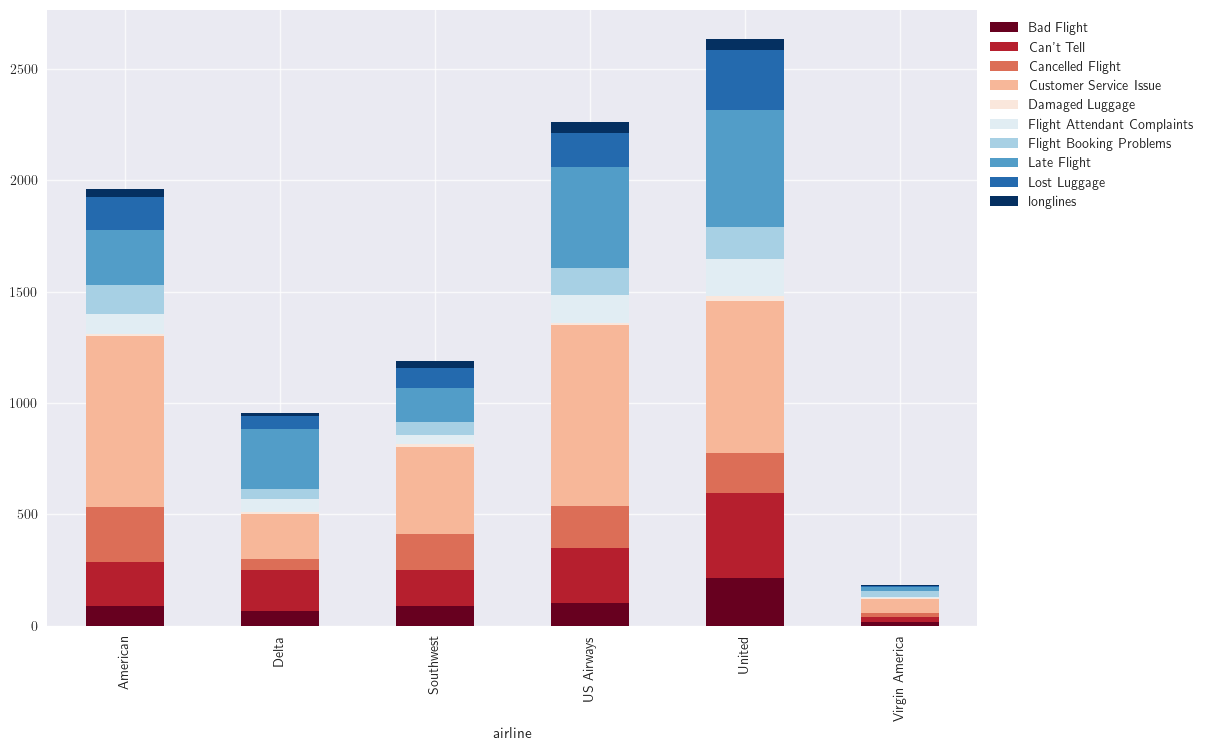

In [27]:
_colors = plt.cm.RdBu(np.linspace(0, 1, 10))
ax = negative_reasons_per_airline.plot(kind="bar", stacked=True, figsize=(12, 8), color=_colors)
ax.legend(bbox_to_anchor=(1.0, 1.0))

As one can see, there is a wide distribution of *negative reasons* when it comes to various airlines. However, it seems that
**Customer Service** and **Late flight** are amongst the more frequent reasons for why customers leave a bad review.

### 2.2 Preprocessing of the data

In order to be able to use the dataset for training a machine learning model we must first clean and preprocess the data that will be used
for our model. In this case, we are planning to use:

1. `airline_sentiment` : Defines the sentiment of the tweet
2. `negative_reason` : Reason for the negative feedback (if negative).
3. `Text` : Tweet text content
4. `tweet_location` : Location, from which the tweet was posted.

Each of these columns need to be preprocessed and cleaned before using it for training the model and validating its performance.

Let's create a subsample of the dataset:

In [28]:
# Creating a subsample of the dataset
columns_subset_arr = ["airline_sentiment", "negativereason", "text", "tweet_location"]
df_subset = dataset_df[columns_subset_arr]

df_subset

,airline_sentiment,negativereason,text,tweet_location
0,neutral,NaN,@VirginAmerica What @dhepburn said.,NaN
1,positive,NaN,@VirginAmerica plus you've added commercials t...,NaN
2,neutral,NaN,@VirginAmerica I didn't today... Must mean I n...,Lets Play
3,negative,Bad Flight,@VirginAmerica it's really aggressive to blast...,NaN
4,negative,Can't Tell,@VirginAmerica and it's a really big bad thing...,NaN
...,...,...,...,...
14635,positive,NaN,@AmericanAir thank you we got on a different f...,NaN
14636,negative,Customer Service Issue,@AmericanAir leaving over 20 minutes Late Flig...,Texas
14637,neutral,NaN,@AmericanAir Please bring American Airlines to...,"Nigeria,lagos"
14638,negative,Customer Service Issue,"@AmericanAir you have my money, you change my ...",New Jersey


Before starting, let's check the distribution of the `airline_sentiment`:

In [29]:
df_subset["airline_sentiment"].value_counts(dropna=False, normalize=True).to_frame()

,proportion
airline_sentiment,
negative,0.626913
neutral,0.211680
positive,0.161407


This shows that about 62.6% of the data is comprised of *negative* reviews, while the remaining ~21% and ~16% if comprised of *neutral* and *positive* reviews, respectively.

#### 2.2.1 Text preparation

We first need to clean the tweets, tokenize their content.

In [30]:
# --- Specifying the NLP pipeline
nltk.download('stopwords')

# Create a list of punctuation marks
punctuations = string.punctuation

# List of stopwords - No custom ones for nowd
# stopwords = spacy.lang.en.stop_words.STOP_WORDS
stopwords = nltk.corpus.stopwords.words('english')

# Function to remove URLs from text
def remove_urls(text):
    text = re.sub(r"\S*https?:\S*", "", text, flags=re.MULTILINE)
    return text


def _tokenize_text(text: str):
    
    # Initializing tokenizer object
    tk = TweetTokenizer(strip_handles=True, reduce_len=True, preserve_case=False)
    
    return tk.tokenize(text)

def _remove_stopwords(text: str):
    
    # Tokenizing text
    tokens = _tokenize_text(text)
    
    # Filtering out stop words
    filtered_tokens = [token for token in tokens if token not in stopwords]
    
    return ' '.join(filtered_tokens)

def _remove_punctuation(text):
    
    nopunc =[char for char in text if char not in string.punctuation]
    nopunc=''.join(nopunc)
    
    return ' '.join([word for word in nopunc.split() if word.lower() not in stopwords])


def prepare_text(text: str):
    """
    Function to tokenize the input text.
    
    Parameters
    ------------
    text : str
        Text that will be tokenized by spaCy.
    
    Returns
    ----------
    text_tokenize : str
        Tokenized version of the input ``text``.
    """
    # Making everything lowercase
    text = text.lower()
    
    # Removing stop words
    tokens = _remove_stopwords(text)
    
    # Removing punctuation
    tokens = _remove_punctuation(tokens)
              
    return tokens


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/vfcalderon/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


We can now apply it to the overall text

In [31]:
# --- Tokenizing the contents of the tweets

# Tokenizing each input
df_subset.loc[:,"processed_text"] = df_subset["text"].apply(prepare_text)
df_subset["processed_text"]

/var/folders/lm/rc_j1sgx687267y6tjc4l5600000gn/T/ipykernel_31808/2287887975.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset.loc[:,"processed_text"] = df_subset["text"].apply(prepare_text)


0                                                     said
1                  plus added commercials experience tacky
2                   today must mean need take another trip
3        really aggressive blast obnoxious entertainmen...
4                                     really big bad thing
                               ...                        
14635                   thank got different flight chicago
14636    leaving 20 minutes late flight warnings commun...
14637          please bring american airlines blackberry10
14638    money change flight answer phones suggestions ...
14639    8 ppl need 2 know many seats next flight plz p...
Name: processed_text, Length: 14640, dtype: object

#### 2.2.2 Preprocess airline sentiment

Additionally, we also need to preprocess the `airline_sentiment` variables, since these are categorical variables and we need to One-Hot encode the variables.

In [32]:
# Defining the mapping for the airline sentiment
# NOTE: This can be further processed using the OneHotEncoder from Scikit-Learn 
airline_sentiment_mapping = dict(zip(["negative", "positive", "neutral"], [0,1,2]))

# Mapping the new values
df_subset.loc[:,"airline_sentiment"] = df_subset["airline_sentiment"].replace(airline_sentiment_mapping)

df_subset

,airline_sentiment,negativereason,text,tweet_location,processed_text
0,2,NaN,@VirginAmerica What @dhepburn said.,NaN,said
1,1,NaN,@VirginAmerica plus you've added commercials t...,NaN,plus added commercials experience tacky
2,2,NaN,@VirginAmerica I didn't today... Must mean I n...,Lets Play,today must mean need take another trip
3,0,Bad Flight,@VirginAmerica it's really aggressive to blast...,NaN,really aggressive blast obnoxious entertainmen...
4,0,Can't Tell,@VirginAmerica and it's a really big bad thing...,NaN,really big bad thing
...,...,...,...,...,...
14635,1,NaN,@AmericanAir thank you we got on a different f...,NaN,thank got different flight chicago
14636,0,Customer Service Issue,@AmericanAir leaving over 20 minutes Late Flig...,Texas,leaving 20 minutes late flight warnings commun...
14637,2,NaN,@AmericanAir Please bring American Airlines to...,"Nigeria,lagos",please bring american airlines blackberry10
14638,0,Customer Service Issue,"@AmericanAir you have my money, you change my ...",New Jersey,money change flight answer phones suggestions ...


The clean dataset now looks like this:

In [33]:
df_clean = df_subset[["airline_sentiment", "negativereason", "processed_text"]]

df_clean

,airline_sentiment,negativereason,processed_text
0,2,NaN,said
1,1,NaN,plus added commercials experience tacky
2,2,NaN,today must mean need take another trip
3,0,Bad Flight,really aggressive blast obnoxious entertainmen...
4,0,Can't Tell,really big bad thing
...,...,...,...
14635,1,NaN,thank got different flight chicago
14636,0,Customer Service Issue,leaving 20 minutes late flight warnings commun...
14637,2,NaN,please bring american airlines blackberry10
14638,0,Customer Service Issue,money change flight answer phones suggestions ...


---

## 3. Training and evaluation of the model

The next step is vectorize the dataset:

In [34]:
# Initializing vectorizer
vectorizer = TfidfVectorizer(use_idf=True, lowercase=True)

# Creating vectorized version of the data
X_tf_idf = vectorizer.fit_transform(df_clean["processed_text"])

# Creating a train/test split
x_train, x_test, y_train, y_test = train_test_split(X_tf_idf, df_clean['airline_sentiment'], random_state=42)

### 3.1 Training the model

Now that we have defined the training / testing datasets, we can now proceed with training our model.
For the first case, we can define the set of statistics and metrics that we'll use to evaluate the
performance of the model, and make it so that we can determine if the model is good or needs some more
fine-tuning.

In [36]:
def _train_and_evaluate_model(clf, X_train, X_test, y_train, y_test):
    """
    Function to train the input model and evaluate the performance metrics
    of the training and validation datasets.
    
    Parameters
    -------------
    clf : model
        Variable corresponding to the input model.
    
    X_train : numpy.ndarray
        Array corresponding to the input features for ``training``.
    
    X_test : numpy.ndarray
        Array corresponding to the input features for ``testing``.
    
    y_train : numpy.ndarray
        Variable corresponding to the target variable in ``training``.
        
    y_test : numpy.ndarray
        Variable corresponding to the target variable in ``testing``.
    """
    # Training the model on training data
    model = clf.fit(X_train, y_train)
    
    # Predicted the classes on the test dataset
    predicted_class_test = model.predict(X_test)
    
    # Predicted the classes on the 'training' dataset
    predicted_class_train = model.predict(X_train)
    
    # Creating predicted columns
    pred_arr = model.predict(X_test)
    
    # Extracting the probabilities of the validation dataset
    test_probs = model.predict_proba(X_test)
    test_probs = test_probs[:, 1]
    
    # Calculating the metrics, such as precision and recall
    lr_precision, lr_recall, _ = precision_recall_curve(y_test, test_probs)
    
    # Calculating metrics such as F1-score, and area-under-curve (auc)
    lr_f1 = f1_score(y_test, yhat)
    lr_auc = auc(lr_recall, lr_precision)
    
    # Calculating ROC
    fpr, tpr, _ = roc_curve(y_test, test_probs)
    
    # --- Providing set of metrics to use
    
    # - Accuracy
    accuracy_train = accuracy_score(y_train, predicted_class_train)
    accuracy_test = accuracy_score(y_test, predicted_class_test)
    
    logger.info(f"Training accuracy: {accuracy_train}")
    logger.info(f"Testing accuracy : {accuracy_test}")
    
    # - ROC and AUC
    train_auc = roc_auc_score(y_train, clf.predict_proba(X_train)[:, 1])
    test_auc = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
    
    logger.info(f"Train ROC-AUC score: {train_auc}")
    logger.info(f"Test ROC-AUC score: {test_auc}")
    
    # --- Recall and precision
    logger.info(f"Precision: {lr_precision}")
    logger.info(f"Recall: {lr_recall}")
    
    # --- Area under the curve
    logger.info(f"Area under Precision-Recall curve?")

    return

In [ ]:
# Validating model
s_train_accu, s_test_accu, s_train_auc, s_test_auc = _train_and_evaluate_model(MultinomialNB(), x_train, y_test, y_train, y_test)